# Reduction de dimension

L'objectif de ce nootebook est de montrer les avantages et inconvenients de la reduction des dimensions sur la classification des données images.

In [37]:
import numpy as np
import cv2 #import OpenCV
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import itertools # Pour créer des iterateurs
from sklearn.metrics import f1_score, make_scorer, classification_report


import os #Miscellaneous operating system interfaces
#https://docs.python.org/3/library/os.html
#get current working directory
path = os.getcwd() + '\\images\\image_train'

In [4]:
X = pd.read_csv('X_train_update.csv',index_col=0)
y = pd.read_csv('Y_train_CVw08PX.csv',index_col=0).squeeze().map(str)

#Create a column with the name of the picture
X['image_name'] = 'image_' + X['imageid'].map(str) + '_product_' + X['productid'].map(str) + '.jpg'
X['image_path'] = path + r'\image_' + X['imageid'].map(str) + '_product_' + X['productid'].map(str) + '.jpg'

## Reduction données entrée

Avant d'appliquer les algorithmes de réduction, on va réduir la taille des images et les utiliser en gris. Ça va permettre de mieux gérer la mémoir de nos machines. Les images vont être sotckés dans un DataFrame avec un pixel par colonne (variable/feature):

Change la taille d'un group d'images à 50x50 pixels:

In [5]:
batch = X.shape[0]
image_size = (50,50)

path_list = list(X['image_path'][:batch])
index_list = list(X[:batch].index)
label_list = list(y[:batch])
images_tuples = []
for path, idx, label in zip(path_list,index_list,label_list):
    img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img_gray_red = cv2.resize(img_gray, dsize = (image_size),interpolation = cv2.INTER_AREA )
    images_tuples.append((idx,label,img_gray_red))

#images_tuples

Creation des noms des colones du nouveau df:

In [6]:
column_names = ['index','label']
for pixel in range(image_size[0]*image_size[1]):
    column_names.append('pixel'+str(pixel+1))
#column_names

Listes des pixels par image a rajouter dans le df:

In [7]:
images_list = []
for image in images_tuples:
    idx,label,img = image
    pixel_list = [idx,label]
    for row_pixels in img:
        for pixel in row_pixels:
            pixel_list.append(pixel)
    images_list.append(pixel_list)

#print('pxl',images_list)

Création du df:

In [8]:
rakuten_images = pd.DataFrame(images_list,columns=column_names)
rakuten_images

In [9]:
rakuten_images.to_csv('rakuten_reduced_all_images.csv',index_label='idx')

Charger le df stocké:

In [10]:
rakuten_reduced_images = pd.read_csv('rakuten_reduced_all_images.csv',index_col='index')
rakuten_reduced_images.drop(columns=['idx'],inplace=True)

Creation des variables et target:

In [11]:
target = rakuten_reduced_images['label']
data = rakuten_reduced_images.drop('label',1)

# Reduction de dimension

## PCA

Analyse de l'impact de la réduction de variables sur la variance du dataset:

In [12]:
from sklearn.decomposition import PCA

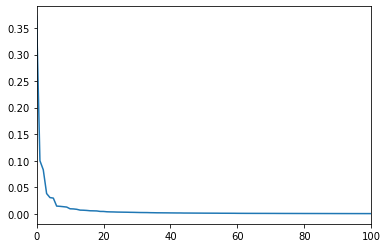

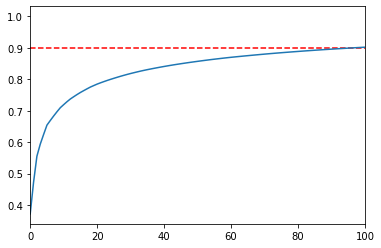

In [14]:
pca = PCA()
pca.fit(data)

plt.figure()
plt.xlim(0,100)
plt.plot(pca.explained_variance_ratio_);

plt.figure()
plt.xlim(0,100)
plt.axhline(y = 0.90, color ='r', linestyle = '--')
plt.plot(pca.explained_variance_ratio_.cumsum());

Calcul des variables nécessaires pour conserver le 90% de variance:

In [19]:
pca = PCA(n_components = 0.90)
pca.fit(data)
print("Nombre de composantes retenues :", pca.n_components_)

Nombre de composantes retenues : 99


Projection des données dans le nouveau space avec 99 varaibles:

In [20]:
#pca = PCA(n_components = 0.90)

X_train = data[:67933]
X_test = X_test = data[67933:]

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [21]:
y_train = y[:67933]
y_test = y[67933:]

Entrainement d'un modèle et caulcul des scores: 

- Dataset complet:

In [27]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_jobs = -1)

clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.4636989931107578

Création d'une fonction propre pour la confusion matrix:

In [31]:
#Variable target avec les labels organisées:
y_organised = ['10','2280','2403','2705','2522',
               '40','50','2905','2462','60',
               '1280','1281','1300','1180','1140','1160',
               '1320','1560',
               '2582','2583','2585','1302','2220',
               '1920','2060',
               '1301','1940'
              ]

def conf_matx(y_test,y_pred):
    #Réponse valable:
    #cnf_matrix = metrics.confusion_matrix(y_test,y_pred,labels=list(set(y_pred)))
    cnf_matrix = metrics.confusion_matrix(y_test,y_pred,labels=y_organised)
    y_organised

    pond_matrix = []
    for line in cnf_matrix:
        pond_line = []
        for cell in line:
            pond_line.append(round(cell/sum(line),2))
        pond_matrix.append(pond_line)
        #print(sum(line))
        #print(sum(pond_line))
    cnf_matrix = np.array(pond_matrix)

    ###Optionnel: Afficher une matrice de confusion sous forme de tableau coloré
    #classes = set(y_pred)
    classes = y_organised

    plt.figure(figsize=(17,17))

    plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
    plt.title("Matrice de confusion")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    #tick_marks = set(y_test)
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

    plt.ylabel('Vrais labels')
    plt.xlabel('Labels prédits')
    plt.show()

              precision    recall  f1-score   support

          10       0.46      0.53      0.49       641
        1140       0.51      0.24      0.33       533
        1160       0.68      0.70      0.69       828
        1180       0.62      0.11      0.19       161
        1280       0.22      0.16      0.18       959
        1281       0.24      0.04      0.06       433
        1300       0.40      0.56      0.47      1009
        1301       0.61      0.23      0.34       162
        1302       0.54      0.19      0.28       452
        1320       0.33      0.23      0.27       617
        1560       0.33      0.37      0.35       977
        1920       0.73      0.69      0.71       828
        1940       0.84      0.17      0.28       181
        2060       0.31      0.42      0.36       966
        2220       1.00      0.09      0.17       173
        2280       0.51      0.61      0.56       949
        2403       0.34      0.62      0.43       964
        2462       0.40    

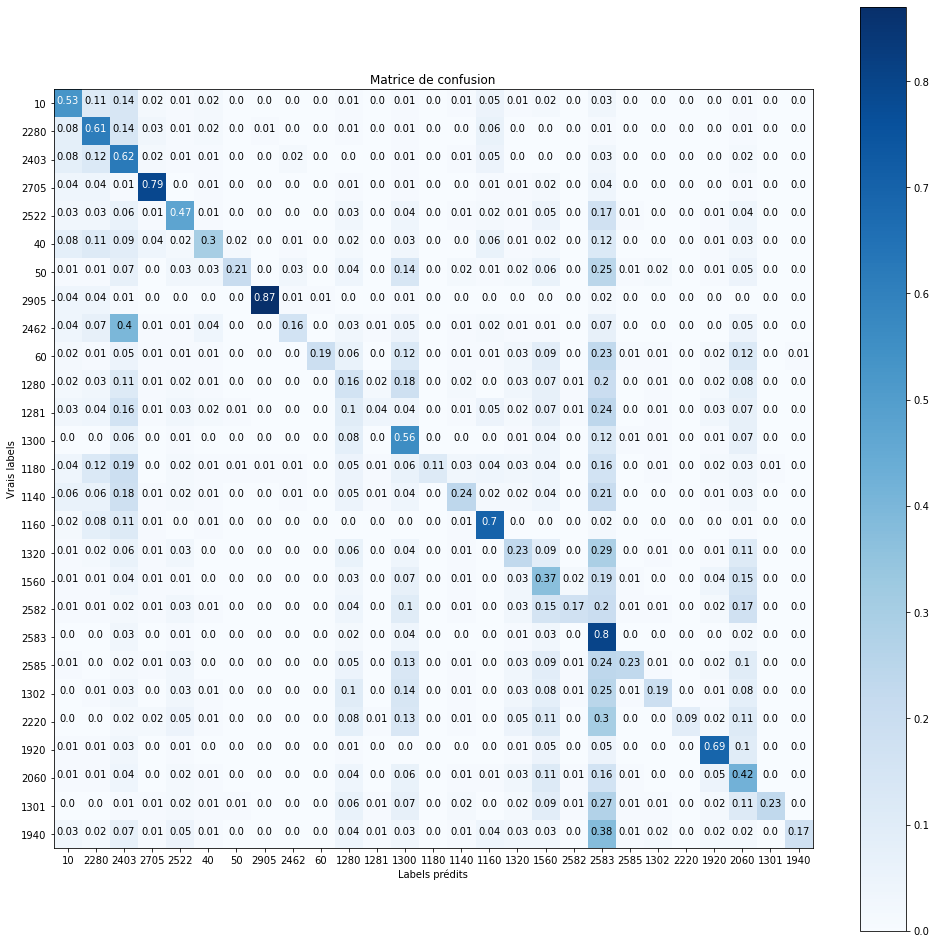

In [38]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
conf_matx(y_test,y_pred) #montre les résultats en pourcentages!

- Dataset reduit:

In [39]:
clf_red = RandomForestClassifier(n_jobs = -1)

clf_red.fit(X_train_pca, y_train)
clf_red.score(X_test_pca, y_test)

0.413472295825237

              precision    recall  f1-score   support

          10       0.45      0.45      0.45       641
        1140       0.40      0.18      0.25       533
        1160       0.58      0.68      0.63       828
        1180       0.75      0.06      0.10       161
        1280       0.18      0.14      0.16       959
        1281       0.23      0.02      0.04       433
        1300       0.37      0.45      0.40      1009
        1301       0.70      0.20      0.32       162
        1302       0.57      0.12      0.19       452
        1320       0.32      0.17      0.22       617
        1560       0.27      0.32      0.29       977
        1920       0.56      0.65      0.60       828
        1940       0.91      0.11      0.20       181
        2060       0.28      0.39      0.32       966
        2220       1.00      0.08      0.15       173
        2280       0.38      0.58      0.46       949
        2403       0.31      0.56      0.40       964
        2462       0.55    

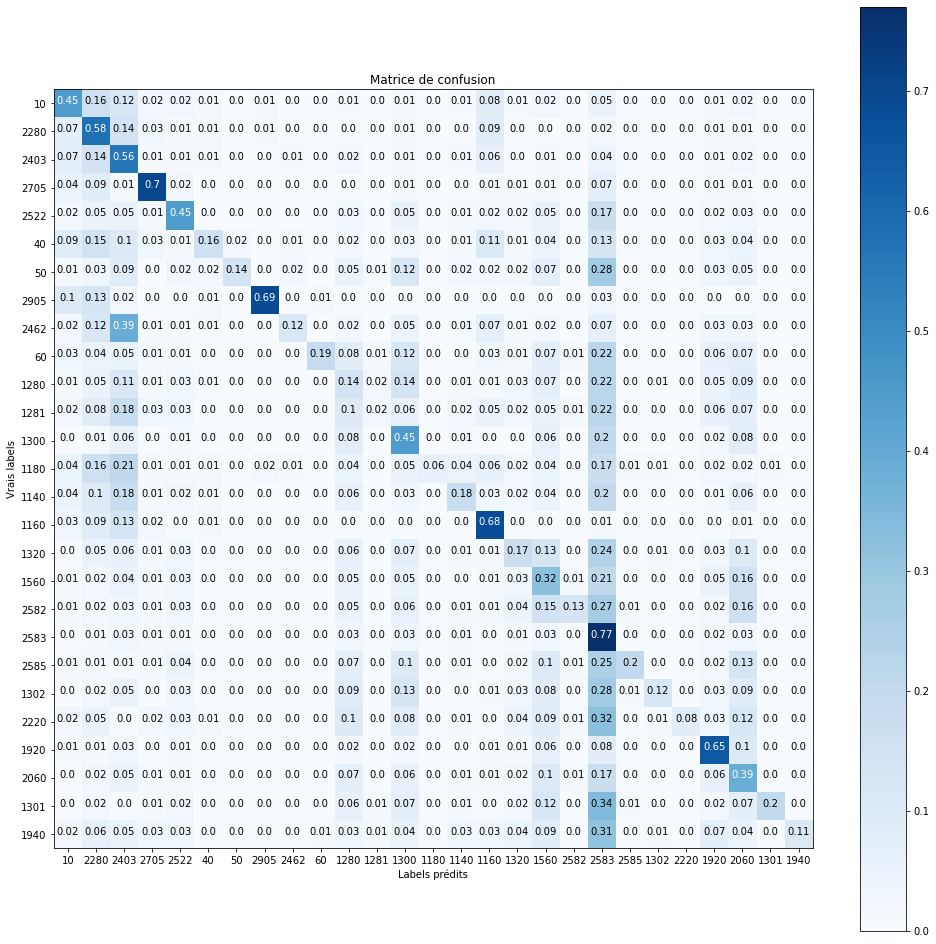

In [41]:
y_pred = clf_red.predict(X_test_pca)
print(classification_report(y_test, y_pred))
conf_matx(y_test,y_pred) #montre les résultats en pourcentages!

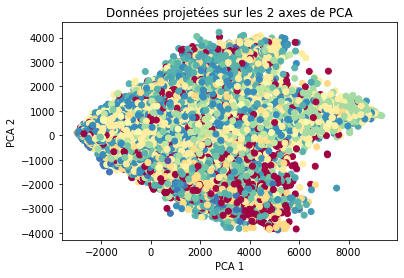

In [6]:
pca = PCA(n_components = 2)
data_2D = pca.fit_transform(data)

fig = plt.figure()

ax = fig.add_subplot(111)
ax.scatter(data_2D[:, 0], data_2D[:, 1], c = target, cmap=plt.cm.Spectral)

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')

ax.set_title("Données projetées sur les 2 axes de PCA")
plt.show();

In [13]:
print("La part de variance expliquée est", round(pca.explained_variance_ratio_.sum(),2))

NameError: name 'pca' is not defined

In [42]:
from sklearn.svm import SVC, LinearSVC

clf_lsvc = LinearSVC(penalty="l2", dual=True, C=0.8, tol=1e-5, max_iter=1000)

In [44]:
clf_lsvc.fit(X_train[:8000],y_train[:8000])
clf_lsvc.score(X_test[:2000], y_test[:2000])

C:\Users\Edgar\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.2125

# LLE

Nous allons appliquer la LLE modifiée sur notre jeu de données réelles et observer comment l'algorithme construit un espace de dimension 2 depuis un espace de dimension 2500.
La réduction de dimension est ici particulièrement forte pour permettre la visualisation. Il est possible que 2 dimensions ne soit pas suffisantes pour isoler un manifold au sein de nos données.

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding, MDS, Isomap, TSNE

In [164]:
lle = LocallyLinearEmbedding(n_neighbors=50, n_components=2, method='modified', random_state = 42)
dataLLE = lle.fit_transform(data)

MemoryError: Unable to allocate 26.8 GiB for an array with shape (60000, 60000) and data type float64

In [ ]:
fig = plt.figure()

ax = fig.add_subplot(111)
ax.scatter(dataLLE[:, 0], dataLLE[:, 1],  c = target, cmap=plt.cm.Spectral, alpha = .7, s = 4)

ax.set_xlabel('LL 1')
ax.set_ylabel('LL 2')

ax.set_title("Manifold 2D identifié par la LLE")
plt.show();

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(data = dataLLE, model = lle, images=data.values.reshape((-1, 28, 28)),
                ax=ax, thumb_frac=0.05, prefit = True)

In [7]:
tsne = TSNE(n_components=2, method = 'barnes_hut')
dataTSNE = tsne.fit_transform(data[:1000])

In [8]:
def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray_r', prefit = False):
    ax = ax or plt.gca()
    
    if not prefit :
        proj = model.fit_transform(data)
    else:
        proj = data
    ax.plot(proj[:, 0], proj[:, 1], '.b')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # On ne montre pas le points trop proches
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

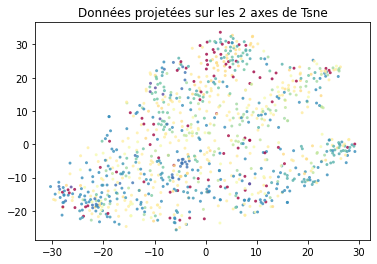

In [30]:
fig = plt.figure()

ax = fig.add_subplot(111)
ax.scatter(dataTSNE[:, 0], dataTSNE[:, 1],  c = target[:1000], cmap=plt.cm.Spectral, alpha = .7, s = 4)

ax.set_title("Données projetées sur les 2 axes de Tsne")
plt.show();

NameError: name 'offsetbox' is not defined

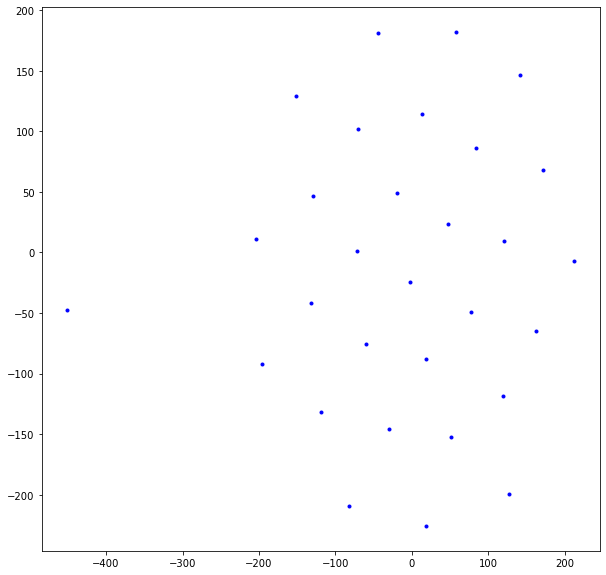

In [29]:
data_mant = data[:1000][target[:1000] == 10]
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(data_mant, tsne, images=data_mant.values.reshape((-1, 50, 50)),
                ax=ax, thumb_frac=0.1, cmap='gray_r')